What's kalman filter?  
materials:  
1.[an interactive tutorial](https://home.wlu.edu/~levys/kalman_tutorial/)

2.[Understanding the Basis of the kalman filter via a simple and intuitive derivation](http://www.cl.cam.ac.uk/~rmf25/papers/Understanding%20the%20Basis%20of%20the%20Kalman%20Filter.pdf)  



other resources:

https://www.quantopian.com/posts/quantopian-lecture-series-kalman-filters

http://www.thealgoengineer.com/2014/online_linear_regression_kalman_filter/

https://www.quantstart.com/articles/Dynamic-Hedge-Ratio-Between-ETF-Pairs-Using-the-Kalman-Filter


search kalman in everything


 when the gain is zero, observation has no effect, and we get the original equation relating the current state to the previous.  
 
 In other words, when the gain is one, the previous state doesn't matter, and we get the current state estimation entirely from the current observation.

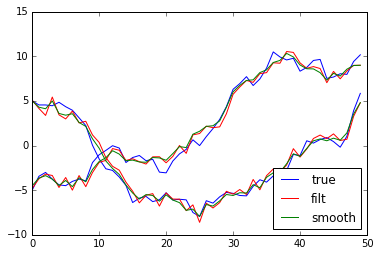

In [8]:
'''
===========================================
Using the Kalman Filter and Kalman Smoother
===========================================
This simple example shows how one may apply the Kalman Filter and Kalman
Smoother to some randomly generated data.
The Kalman Filter and Kalman Smoother are two algorithms for predicting the
hidden state of Linear-Gaussian system. In this script, all model parameters
are specified beforehand, so there is no need to fit the Kalman Filter's
parameters to the measurements. However, this is not essential; sensible
defaults will be used for unspecified parameters, and they may be learned using
:func:`KalmanFilter.em`.
The figure drawn shows the true, hidden state, the state estimates given by the
Kalman Filter, and the state estimates given by the Kalman Smoother.
'''
import numpy as np
import pylab as pl
from pykalman import KalmanFilter

# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
transition_covariance = np.eye(2)
observation_covariance = np.eye(2) + random_state.randn(2, 2) * 0.1
initial_state_mean = [5, -5]
initial_state_covariance = [[1, 0.1], [-0.1, 1]]

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
states, observations = kf.sample(
    n_timesteps=50,
    initial_state=initial_state_mean
)

# estimate state with filtering and smoothing
filtered_state_estimates = kf.filter(observations)[0]
smoothed_state_estimates = kf.smooth(observations)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_filt = pl.plot(filtered_state_estimates, color='r')
lines_smooth = pl.plot(smoothed_state_estimates, color='g')
pl.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
pl.show()

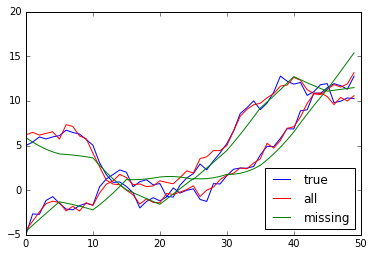

In [9]:
'''
====================================================
Applying the Kalman Filter with Missing Observations
====================================================
This example shows how one may apply :class:`KalmanFilter` when some
measurements are missing.
While the Kalman Filter and Kalman Smoother are typically presented assuming a
measurement exists for every time step, this is not always the case in reality.
:class:`KalmanFilter` is implemented to recognize masked portions of numpy
arrays as missing measurements.
The figure drawn illustrates the trajectory of each dimension of the true
state, the estimated state using all measurements, and the estimated state
using every fifth measurement.
'''
import numpy as np
import pylab as pl
from pykalman import KalmanFilter

# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
initial_state_mean = [5, -5]
n_timesteps = 50

# sample from model
kf = KalmanFilter(
    transition_matrices=transition_matrix,
    observation_matrices=observation_matrix,
    transition_offsets=transition_offset,
    observation_offsets=observation_offset,
    initial_state_mean=initial_state_mean,
    random_state=0
)
states, observations_all = kf.sample(
    n_timesteps, initial_state=initial_state_mean
)

# label half of the observations as missing
observations_missing = np.ma.array(
    observations_all,
    mask=np.zeros(observations_all.shape)
)
for t in range(n_timesteps):
    if t % 5 != 0:
        observations_missing[t] = np.ma.masked

# estimate state with filtering and smoothing
smoothed_states_all = kf.smooth(observations_all)[0]
smoothed_states_missing = kf.smooth(observations_missing)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_smooth_all = pl.plot(smoothed_states_all, color='r')
lines_smooth_missing = pl.plot(smoothed_states_missing, color='g')
pl.legend(
    (lines_true[0], lines_smooth_all[0], lines_smooth_missing[0]),
    ('true', 'all', 'missing'),
    loc='lower right'
)
pl.show()

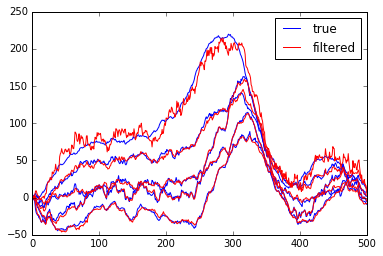

In [10]:
'''
==============================================
Online State Estimation with the Kalman Filter
==============================================
This example shows how :class:`KalmanFilter` can be used to estimate hidden
states in an online setting.
While the Kalman Smoother is able to estimate the hidden state of a target at
any time step using *all* measurements, the Kalman Filter only uses
measurements up to and including the current time step.  This is done using a
set of recursive formulae that only require the mean and covariance matrix
output by the Kalman Filter at the previous time step, meaning that we may
apply the Kalman Filter in an online manner.
The drawn figure shows two sets of lines; the first represents the true, hidden
state of the target, while the second represents the estimates output by the
Kalman Filter.
'''
import numpy as np
import pylab as pl

from pykalman.datasets import load_robot
from pykalman import KalmanFilter

# Initialize the Kalman Filter
data = load_robot()
kf = KalmanFilter(
    data.transition_matrix,
    data.observation_matrix,
    data.initial_transition_covariance,
    data.initial_observation_covariance,
    data.transition_offsets,
    data.observation_offset,
    data.initial_state_mean,
    data.initial_state_covariance,
    random_state=0
)

# Estimate mean and covariance of hidden state distribution iteratively.  This
# is equivalent to
#
#   >>> (filter_state_means, filtered_state_covariance) = kf.filter(data)
n_timesteps = data.observations.shape[0]
n_dim_state = data.transition_matrix.shape[0]
filtered_state_means = np.zeros((n_timesteps, n_dim_state))
filtered_state_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
for t in range(n_timesteps - 1):
    if t == 0:
        filtered_state_means[t] = data.initial_state_mean
        filtered_state_covariances[t] = data.initial_state_covariance
    filtered_state_means[t + 1], filtered_state_covariances[t + 1] = (
        kf.filter_update(
            filtered_state_means[t],
            filtered_state_covariances[t],
            data.observations[t + 1],
            transition_offset=data.transition_offsets[t],
        )
    )

# draw estimates
pl.figure()
lines_true = pl.plot(data.states, color='b')
lines_filt = pl.plot(filtered_state_means, color='r')
pl.legend((lines_true[0], lines_filt[0]), ('true', 'filtered'))
pl.show()

fitted model: <pykalman.standard.KalmanFilter object at 0x00000239E7A45518>


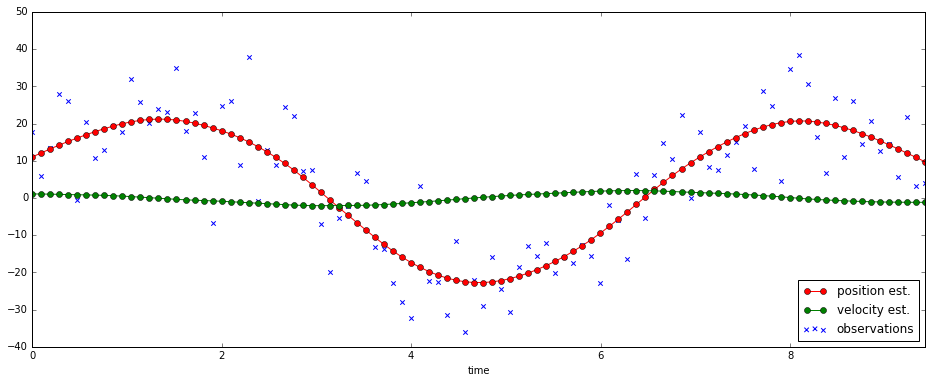

In [11]:
r'''
==================================
Kalman Filter tracking a sine wave
==================================
This example shows how to use the Kalman Filter for state estimation.
In this example, we generate a fake target trajectory using a sine wave.
Instead of observing those positions exactly, we observe the position plus some
random noise.  We then use a Kalman Filter to estimate the velocity of the
system as well.
The figure drawn illustrates the observations, and the position and velocity
estimates predicted by the Kalman Smoother.
'''
import numpy as np
import pylab as pl

from pykalman import KalmanFilter

rnd = np.random.RandomState(0)

# generate a noisy sine wave to act as our fake observations
n_timesteps = 100
x = np.linspace(0, 3 * np.pi, n_timesteps)
observations = 20 * (np.sin(x) + 0.5 * rnd.randn(n_timesteps))

# create a Kalman Filter by hinting at the size of the state and observation
# space.  If you already have good guesses for the initial parameters, put them
# in here.  The Kalman Filter will try to learn the values of all variables.
kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.01 * np.eye(2))

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_pred = kf.em(observations).smooth(observations)[0]
print('fitted model: {0}'.format(kf))

# Plot lines for the observations without noise, the estimated position of the
# target before fitting, and the estimated position after fitting.
pl.figure(figsize=(16, 6))
obs_scatter = pl.scatter(x, observations, marker='x', color='b',
                         label='observations')
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')
velocity_line = pl.plot(x, states_pred[:, 1],
                        linestyle='-', marker='o', color='g',
                        label='velocity est.')
pl.legend(loc='lower right')
pl.xlim(xmin=0, xmax=x.max())
pl.xlabel('time')
pl.show()